In [1]:
import numpy as np
from scipy.special import expit

In [2]:
import matplotlib.pyplot as plt

In [92]:
class RBM:
    
    def __init__(self,n_visible,n_hidden, particles = thr, beta=1,precision=64):
        if precision == 64:
            self.np_type = np.float64
        elif precision == 32:
            self.np_type = np.float32
        self.n_visible = n_visible # number of visible units
        self.n_hidden = n_hidden # number of hidden units
        self.particles = particles
        # initialize weights
        self.W = np.random.normal(loc = 0, scale = 0.01, size = (n_visible, n_hidden)).astype(self.np_type)
        # initialize bias for visible layer
        self.b = np.zeros(shape = (1,n_visible), dtype=self.np_type)
        # initialize bias for hidden layer
        self.c = np.zeros(shape = (1,n_hidden), dtype=self.np_type)
        
        self.beta = beta # temparature
        self.N = np.random.randint(low=0, high=2, size=(particles,self.n_visible)).astype(int)
        self.global_step = 0
        self.W_hist = []
        
        
    def getParameters(self):
        params = {}
        params['W'] = self.W
        params['b'] = self.b
        params['c'] = self.c
        return params
    
    def setParameters(self, W, b, c):
        # checks shapes of parameters
        if W.shape != self.W.shape:
            raise ValueError("The size of weights is invalid.")
        if b.shape != self.b.shape:
            raise ValueError("The size of bias for visible units is invalid.")
        if c.shape != self.c.shape:
            raise ValueError("The size of bias for hidden units is invalid.")
        
        self.W = W
        self.b = b
        self.c = c
    
    def sample(self, iterations = 100, size = 1):
        return self.sampleFrom(np.random.randint(low=0, high=2, size=(size,self.n_visible)), iterations = iterations, size = size)

    #
    # Sample from the learned distribution, starting at some
    # initial value
    #
    def sampleFrom(self, initial, iterations = 100, size = 1):
        V = initial.astype(int)
        for i in range(iterations):
            V, _ = self.sampleGibbs(V, size = size)
            if (iterations > 1000):
                if 0 == i % 1000:
                    print("Sampling iteration ", i)
        return V
        
    def sampleGibbs(self, V, size = 1):
        """
        Run one-step Gibbs sampling
        """
        
        # 1. Sample hidden units from visible units
        # compute expected value of hidden units given visible units
        E_h = expit(self.beta*(V.astype(int)@self.W + self.c), dtype=self.np_type)
        # random samples from uniform distribution U(0,1)
        U = np.random.random_sample(size=(size, self.n_hidden)).astype(self.np_type)
        # updates hidden units
        H = (U <= E_h).astype(int)
        
        # compute expected value of visible units given the hidden units
        E_v = expit(self.beta*(H@np.transpose(self.W) + self.b), dtype=self.np_type)
        U = np.random.random_sample(size=(size, self.n_visible)).astype(self.np_type)
        # update visible units
        Vb = (U <= E_v).astype(int)
        
        return Vb, E_h
        
        
    def train_CD(self, V, iterations = 100, epochs = 1, step = 0.01, weigth_decay=0.0001):
        """
        Contrastive Divergence 
        """
        batch_size = V.shape[0]
        if V.shape[1] != self.n_visible:
            print("Shape of training data", V.shape)
            raise ValueError("Data does not match number of visible units.")
            
        # logs
        dw = []
        errors = []
        self.W_hist = np.zeros((self.W.shape[0],self.W.shape[1],iterations+1))
        self.W_hist[:,:,0] = self.W
        for i in range(iterations):
            # run one Gibss sampling and obtain new values
            # for visible units and previous expectation values
            Vb, E = self.sampleGibbs(V, batch_size)
            
            # Calculate new expectation values
            Eb = expit(self.beta*(Vb@self.W + self.c), dtype=self.np_type)
            
            # Calculate contributions of positive and negative phase
            # and update weights and bias
            
            pos = np.tensordot(V,E,axes=((0),(0))).astype(self.np_type) # data
            neg = np.tensordot(Vb, Eb, axes=((0),(0))).astype(self.np_type) # model
            
            # weight update
            dW = step*self.beta*(pos -neg) / float(batch_size)
            self.W += dW
            # bias update
            self.b += step*self.beta*np.sum(V - Vb, 0) / float(batch_size)
            self.c += step*self.beta*np.sum(E - Eb, 0) / float(batch_size)
            self.W_hist[:,:,i+1] = self.W
            # update logs
            dw.append(np.linalg.norm(dW))
            recon_error = np.linalg.norm(V-Vb)
            errors.append(recon_error)
            if 0 == (self.global_step % 100):
                print("Iteration ", self.global_step," - reconstruction error is now", recon_error)
            self.global_step +=1 
        return dw, errors
    
    def train_PCD(self, V, iterations=10000, epochs=1,step = 0.01,lr=0.001, weight_decay=0.0001):
        """
        Input:
            - V:
            - iterations: 
            - epochs: 
            - lr: learning rate (default is 0.001)
            - weight_decay : the strength of L2 norm (default is 0.0001)
        Output: 
            - dw : 
            - errors : 
        """
        #check shape
        batch_size = V.shape[0]
        if (V.shape[1] != self.n_visible):
            print("Shape of training data", V.shape)
            raise ValueError("Data does not match number of visible units")
        initial_step_size = step
        
        # logs
        dw = []
        errors = []
        
        for i in range(iterations):
            # update step size
            step = initial_step_size * (1.0-(1.0*self.global_step)/(1.0*iterations*epochs))
            # compute negative phase
            self.N, _ = self.sampleGibbs(self.N, size=self.particles)
            # use this to caculate the negative phase
            Eb = expit(self.beta*(self.N@self.W + self.c), dtype=self.np_type)
            neg = np.tensordot(self.N,Eb,axes=((0),(0))).astype(self.np_type)
            # compute the positive phase
            E_h = expit(self.beta*(V@self.W + self.c))
            pos = np.tensordot(V, E_h, axes=((0),(0)))
            # update weights w_{t+1} = w_{t} + 
            dW = step*self.beta*(pos -neg) / float(batch_size) - step*weight_decay*self.W / float(batch_size)
            self.W += dW
            self.b += step*self.beta*np.sum(V - self.N, 0) / float(batch_size) 
            self.c += step*self.beta*np.sum(E_h - Eb, 0) / float(batch_size) 
            
            if 0 == (self.global_step % 50):
                Vb = self.sampleFrom(initial = V, size=batch_size, iterations = 1)
                recon_error = np.linalg.norm(V - Vb) 
                errors.append(recon_error)
                if 0 == (self.global_step % 500):
                    print("Iteration ",self.global_step,"recon error is ", recon_error)
            self.global_step +=1
        return dw, errors
    
    """
    def comput_likelihood(self, V):
        This function computes the likelihood given the data
        Input: 
            - V: the set of images
        Outpu:
            - lik : the likelihood
        # L(\theta) = \prod_{i=1}^{n}p(v_i|h,\theta)
        lik = 
        
    def plot_error(self):
    """
            

In [93]:
from mnist import MNIST
mndata = MNIST('./')
x_train, y_train = mndata.load_training()
x_test, y_test = mndata.load_testing()

In [94]:
x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.int32)
x_test = np.asarray(x_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.int32)

In [373]:
thr = 100
rbm = RBM(784,784,thr)
rbm.particles = thr

V = np.zeros((thr,784))
labels = [3]#[0,1,2,3,4,5,6,7,8,9]
num = 0

for i in range(len(x_train)):
    if y_train[i] in labels:
        V[num,:] = x_train[i]/255
        num += 1
    if num >= thr:
        break

In [374]:
dw, errors = rbm.train_CD(V=V,iterations=100)

Iteration  0  - reconstruction error is now 194.61949153391254


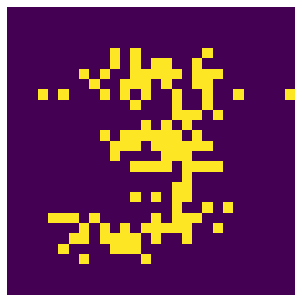

In [383]:
sample = rbm.sample()
fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(sample.reshape([28,28]))
fig.savefig("cd3.png")

In [107]:
temp = V[1,:].reshape([28,28])

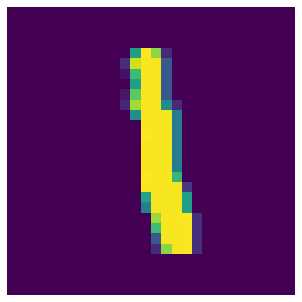

In [108]:
fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(temp)
#fig.savefig("data0.png")

In [72]:
W_hist = rbm.W_hist
print(W_hist.shape)

(784, 784, 1001)
